In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
from random import randrange
import networkx as nx
import re
import os


class Graph:
    '''
    Graph class that accpets file path as an argument
    '''
    
    def __init__(self, path):
#         # Dictionary of pointers of all vertices in th graph
#         self._graph_object = {}
        # Dictionary of all vertices name
        self._graph = {}
        self._coordinates = self.read_tsp_file(path)
        self._cities = [*self._coordinates.keys()]
        self._size = len(self._cities)
        self._distances = self.compute_distances()
        self._file_index = 0
        
        
    def reset_file_index(self):  
        self._file_index = 0
        return

    def read_tsp_file(self, path):
        """"
        Read TSP file
        """
        city_list = []

        with open(path, 'r') as f:
            _data = re.findall(r'\n([0-9].*)', f.read())

        # Split each line by space and convert to float
        for line in _data:
            city_list.append(tuple(map(float, line.split())))
        return { int(vertex): (x,y) for vertex, x, y in city_list }
    
    def euclidean_distance(self, cityA, cityB):
        """
        Formula to calculate the Euclidean distance 
        """
        # Math library
        import math
        
        x1 = self._coordinates[cityA][0]
        y1 = self._coordinates[cityA][1]
        x2 = self._coordinates[cityB][0]
        y2 = self._coordinates[cityB][1]
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
        # add node k between node i and node j
    def add(self, i, j, k):
        print(f'I: {i} - {self._distances[i][k]} K {k} - {self._distances[k][j]}  J {j} - {self._distances[i][j]}')
        print(round(self._distances[i][k] + self._distances[k][j] - self._distances[i][j], 2))
        return round(self._distances[i][k] + self._distances[k][j] - self._distances[i][j], 2)

    
    def compute_distances(self):
        self.distances = defaultdict(dict)
        for cityA in self._cities:
            for cityB in self._cities:
                if cityA != cityB and cityB not in self.distances[cityA]:
#                 if cityB not in self.distances[cityA]:
                    distance = self.euclidean_distance(cityA, cityB)
                    self.distances[cityA][cityB] = round(distance, 2)
                    self.distances[cityB][cityA] = round(distance, 2)
        return self.distances
    
    
    def closest_neighbor(self, tour, node, in_tour=False):
        neighbors = self._distances[node]
#         print(neighbors.items())
        current_dist = [(c, d) for c, d in neighbors.items()
                        if (c in tour if in_tour else c not in tour)]
        return sorted(current_dist, key=itemgetter(1))[-0]
#         return sorted(current_dist, key=itemgetter(1))[-farthest]

    def format_solution(self, solution):
        return [self._coordinates[city] for city in solution]
    
    
    def nearest_insertion(self):
        # Choose ramdom city
        city = randrange(1, self._size)
#         city = 5
        print(f'Random city: {city}')
        tour, tours = [city], []
        print(f'Tour: {tour}\nTours: {tours}')
        # Find the closest node to the first random node which is not in the tour yet
        neighbor, distance = self.closest_neighbor(tour, city, False)
        print(f'Closest Neighbor: {neighbor}\nDistance: {distance}')
        tour.append(neighbor)
        tour_length = distance
        print(f'Tour: {tour}\nTours length: {tour_length}')
        count = 0
        while len(tour) != len(self._cities):
            best, dist = None, float('inf')
#             print(f'Best: {best}\nDist: {dist}')
            
            # (selection step) given a sub-tour,we find node r not in the
            # sub-tour closest to any node j in the sub-tour,
            # i.e. with minimal c_rj
            for candidate in self._cities:
                if candidate in tour:
                    continue
                # we consider only the distances to nodes already in the tour
                _, length = self.closest_neighbor(tour, candidate, True)
                print(length)
                if length < dist:
                    best, dist = candidate, length
            count += 1
            print(f'Best: {best}\nDist: {dist}')
            if count == len(self._cities):
                break
            # (insertion step) we find the arc (i, j) in the sub-tour which
            # minimizes cir + crj - cij, and we insert r between i and j
            idx, dist = None, float('inf')
            print(f'Old Tour: {tour}')
            tour = tour + [tour[0]]
            print(f'New Tour: {tour}')
            for i in range(len(tour) - 1):
                add = self.add(tour[i], tour[i + 1], best)
#                 print(f'Add: {add}')
                if add < dist:
                    idx, dist = i, add
            tour_length += self.add(tour[idx], tour[idx + 1], best)
            tours.append(tour)
            print(f'BEFORE: {tour}')
            tour.insert(idx + 1, best)
            print(f'AFTER: {tour}')
            tour = tour[:-1]
            print("\nFIRTS LOOP COMPLETED\n")
        tour_length += self._distances[tour[0]][tour[-1]]
        print(f'Final tour: {tours}')
#         best_lengths = list(map(self._compute_length, tours))
        tour_coord = [self.format_solution(step) for step in tours]
#         return [self.format_solution(step) for step in tours]
        return [tours, tour_coord]


    def draw_closest_insertion(self, tour, weights=False): 
        '''
        Plot a function 
        '''
        # Create new graph
        G = nx.Graph()
        pos = self._coordinates
#         padding = str(self._file_index).rjust(len(self._coordinates), '0')
#         padding = f'{self._file_index}:02d'
        plot_name = f'{self._file_index:0{len(str(self._size))}d}'

        # Add edges to the graph
        for i in range(len(tour)-1):
            G.add_edge(tour[i], tour[i+1], weight = self._distances[tour[i]][tour[i+1]])

        # Display weights of each edge
        if weights: 
            # Get weight for each edge 
            labels = nx.get_edge_attributes(G,'weight')
            # Drow weights to each edge
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

        # Add nodes 
        options = {"node_size": 500, "alpha": 0.5}
        nx.draw_networkx_nodes(G, pos, nodelist=list(pos.keys()), node_color="r", **options)

        # Draw in red edges that are not in shortest path
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=G.edges(),
            width=0.5,
            alpha=0.5,
            edge_color="r",
        )

        # Draw lables in the node
        nx.draw_networkx_labels(G,pos, font_size=10)

        # Increase the size of the plots
        fig = plt.gcf()
        fig.set_size_inches(18, 10.5)
        #plt.figure(1,figsize=(50,50))

        plt.axis("off")
        plt.title('Closest Insertion Algorithm')
#         k = 2
        plt.savefig(f'graphs/project_3_{plot_name}.png')
        plt.show()
        # Generate the file name in ascending order 
        self._file_index += 1



# Instantiate graph 
graph = Graph('Random30.tsp')
print(graph._coordinates, '\n')
print(graph._cities[-2], '\n')
print(graph._distances[5], '\n')
# print(graph.closest_neighbor([4], 5, True))
test = graph.nearest_insertion()
print(test[0])

{1: (87.951292, 2.658162), 2: (33.466597, 66.682943), 3: (91.778314, 53.807184), 4: (20.526749, 47.63329), 5: (9.006012, 81.185339), 6: (20.03235, 2.761925), 7: (77.18131, 31.922361), 8: (41.059603, 32.578509), 9: (18.692587, 97.01529), 10: (51.658681, 33.808405), 11: (44.563128, 47.541734), 12: (37.80633, 50.599689), 13: (9.961241, 20.337535), 14: (28.186895, 70.415357), 15: (62.129582, 6.18305), 16: (50.376904, 42.796106), 17: (71.285134, 43.671987), 18: (34.156316, 49.113437), 19: (85.201575, 71.837519), 20: (27.466659, 1.394696), 21: (97.985778, 44.746239), 22: (40.730003, 98.40083), 23: (73.79986, 61.076693), 24: (85.076449, 17.029328), 25: (16.052736, 11.899167), 26: (20.160527, 67.23838), 27: (22.730186, 99.725333), 28: (77.19657, 88.503677), 29: (18.494217, 31.971191), 30: (72.743919, 16.071047)} 

29 

{1: 111.35, 2: 28.44, 3: 87.18, 4: 35.47, 6: 79.19, 7: 84.11, 8: 58.22, 9: 18.56, 10: 63.75, 11: 48.95, 12: 42.01, 13: 60.86, 14: 22.0, 15: 91.91, 16: 56.44, 17: 72.7, 18: 40.76

I: 12 - 60.46 K 21 - 63.98  J 18 - 3.94
120.5
I: 18 - 63.98 K 21 - 80.51  J 29 - 23.22
121.27
I: 29 - 80.51 K 21 - 82.78  J 20 - 31.87
131.42
I: 20 - 82.78 K 21 - 88.54  J 6 - 7.56
163.76
I: 6 - 88.54 K 21 - 88.27  J 25 - 9.97
166.84
I: 25 - 88.27 K 21 - 91.35  J 13 - 10.41
169.21
I: 13 - 91.35 K 21 - 77.51  J 4 - 29.27
139.59
I: 4 - 77.51 K 21 - 81.01  J 26 - 19.61
138.91
I: 26 - 81.01 K 21 - 96.15  J 5 - 17.86
159.3
I: 3 - 10.98 K 21 - 26.72  J 17 - 22.86
14.84
BEFORE: [5, 9, 27, 22, 14, 2, 16, 23, 28, 19, 3, 17, 7, 24, 1, 30, 15, 10, 8, 11, 12, 18, 29, 20, 6, 25, 13, 4, 26, 5]
AFTER: [5, 9, 27, 22, 14, 2, 16, 23, 28, 19, 3, 21, 17, 7, 24, 1, 30, 15, 10, 8, 11, 12, 18, 29, 20, 6, 25, 13, 4, 26, 5]

FIRTS LOOP COMPLETED

Final tour: [[5, 14, 26, 5], [5, 14, 2, 26, 5], [5, 14, 2, 12, 26, 5], [5, 14, 2, 12, 18, 26, 5], [5, 14, 2, 11, 12, 18, 26, 5], [5, 14, 2, 16, 11, 12, 18, 26, 5], [5, 14, 2, 16, 10, 11, 12, 18, 26, 5], [5, 14, 2, 16, 10, 8, 11, 12, 18, 26, 5], [5, 14, 2, 16, 10, 8, 1

[(87.951292, 2.658162), (33.466597, 66.682943), (91.778314, 53.807184), (20.526749, 47.63329), (9.006012, 81.185339), (20.03235, 2.761925), (77.18131, 31.922361), (41.059603, 32.578509), (18.692587, 97.01529), (51.658681, 33.808405), (44.563128, 47.541734), (37.80633, 50.599689), (9.961241, 20.337535), (28.186895, 70.415357), (62.129582, 6.18305), (50.376904, 42.796106), (71.285134, 43.671987), (34.156316, 49.113437), (85.201575, 71.837519), (27.466659, 1.394696), (97.985778, 44.746239), (40.730003, 98.40083), (73.79986, 61.076693), (85.076449, 17.029328), (16.052736, 11.899167), (20.160527, 67.23838), (22.730186, 99.725333), (77.19657, 88.503677), (18.494217, 31.971191), (72.743919, 16.071047)] 



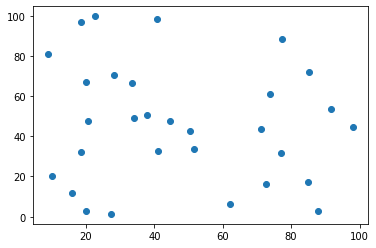

In [2]:
print(list(graph._coordinates.values()), '\n')
x = [coord[0] for coord in graph._coordinates.values()]
y = [coord[1] for coord in graph._coordinates.values()]

# print(x)

import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.show()

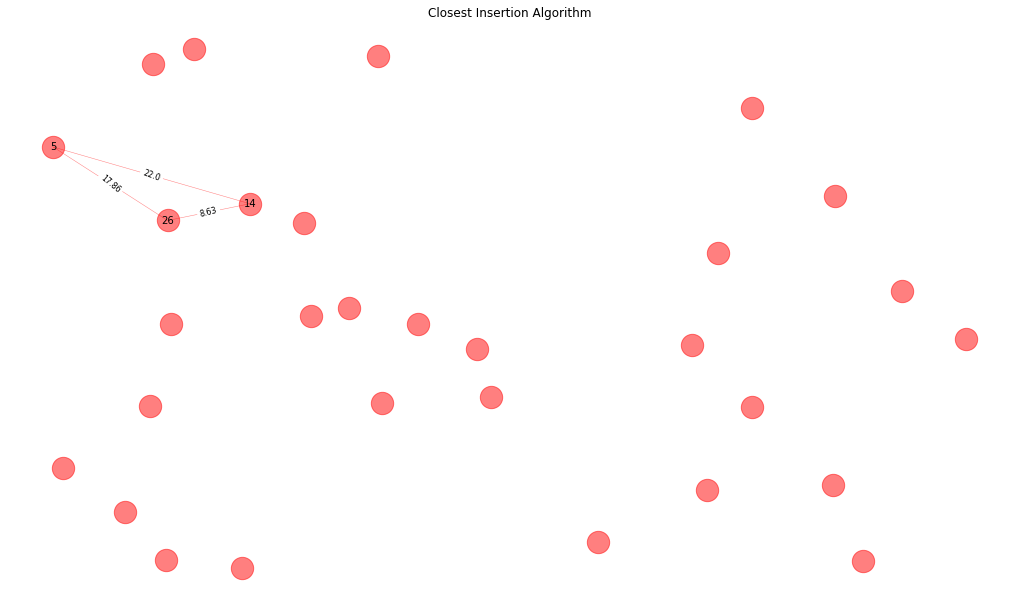

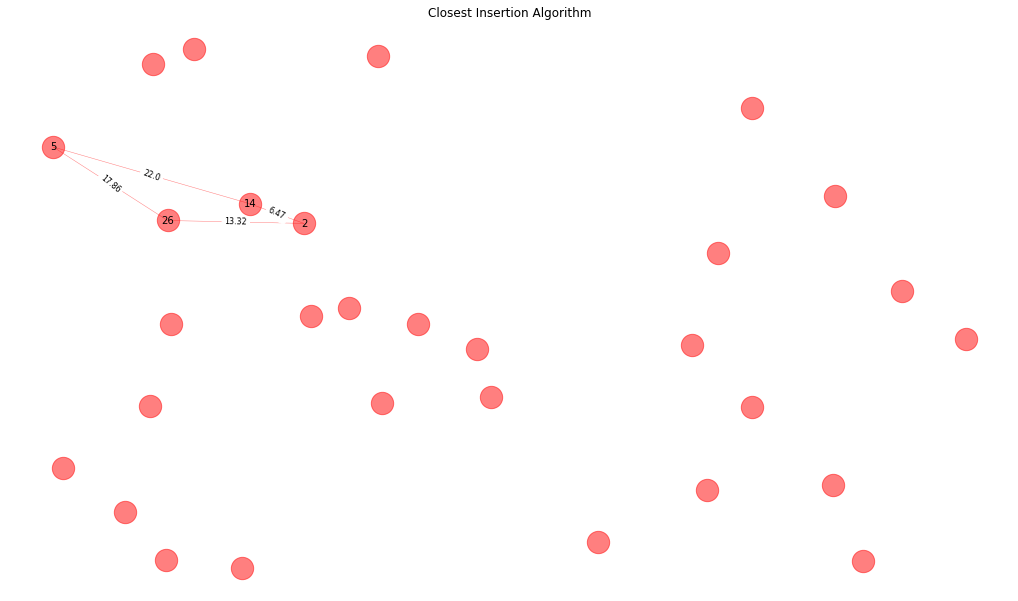

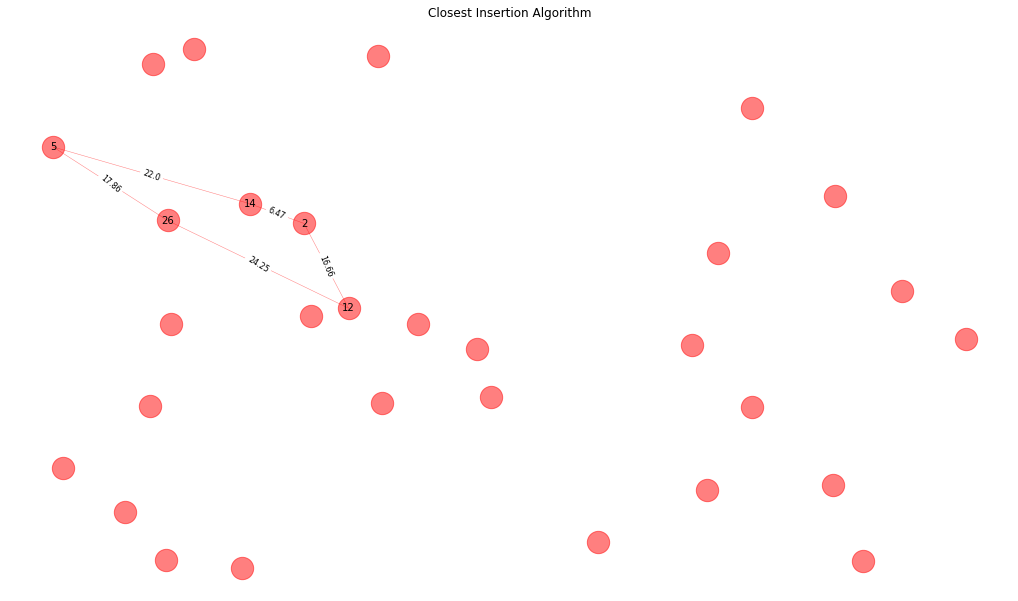

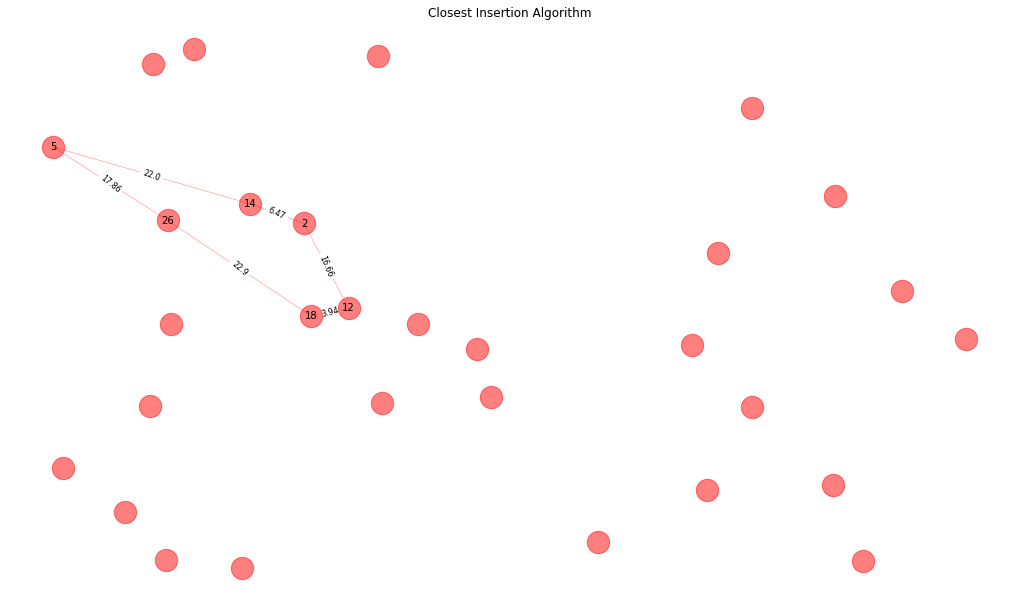

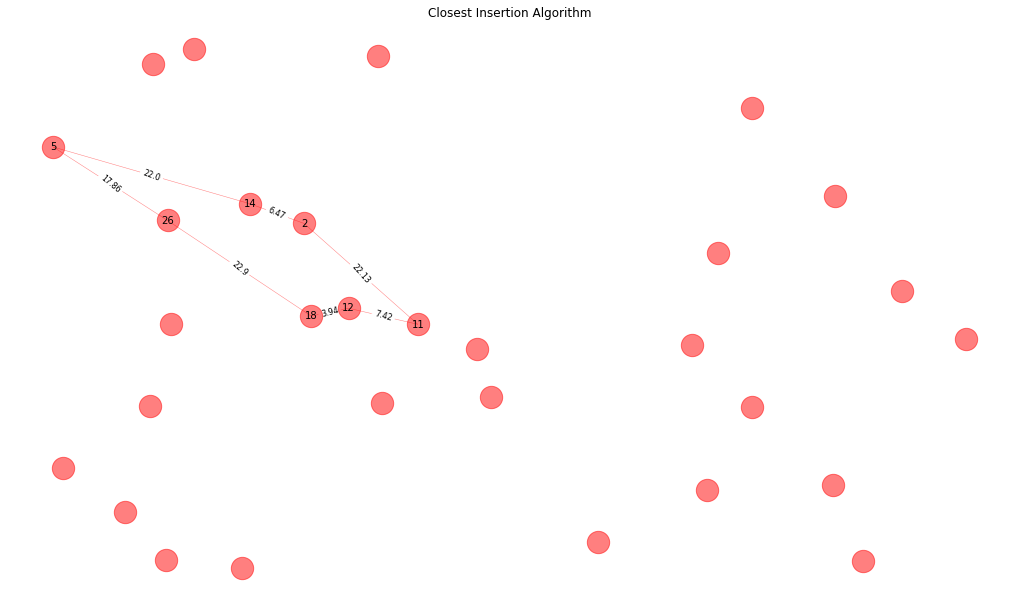

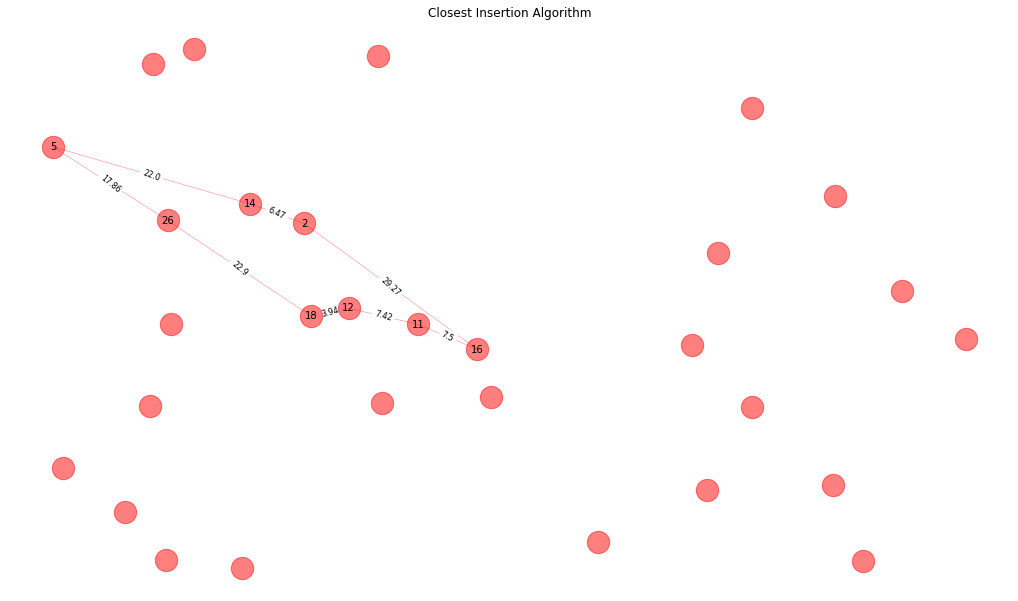

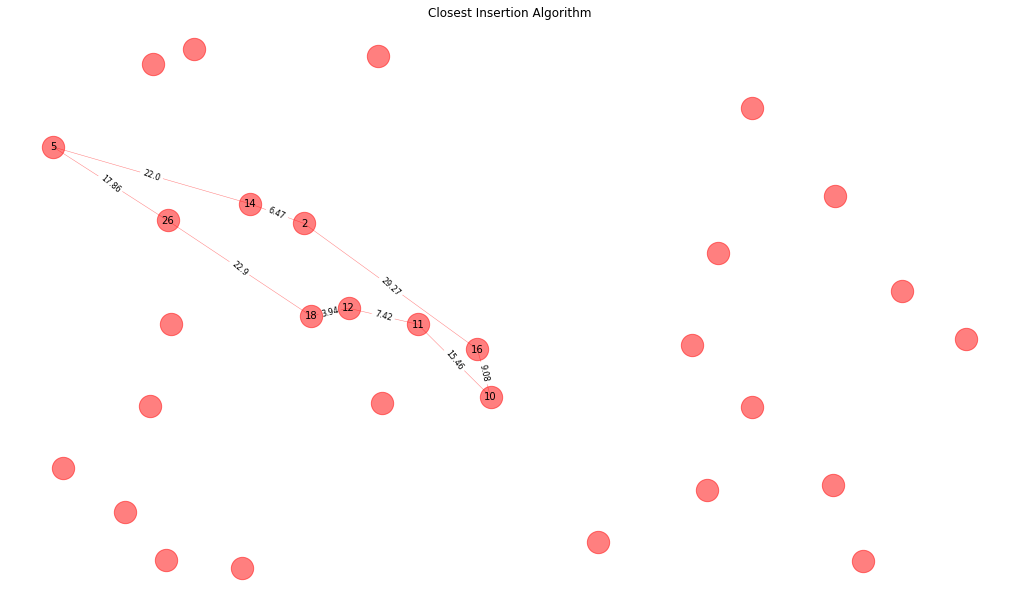

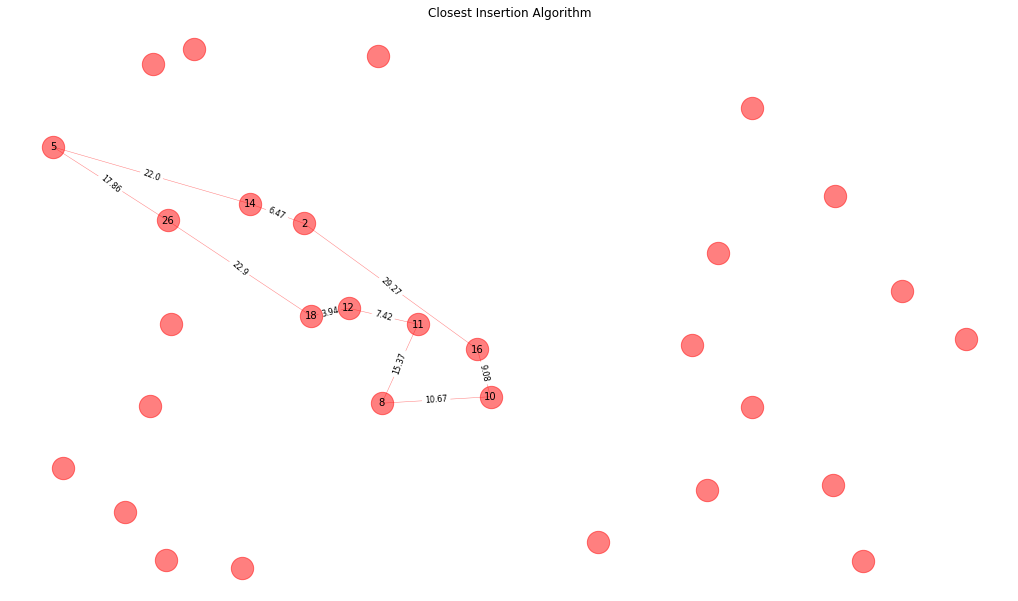

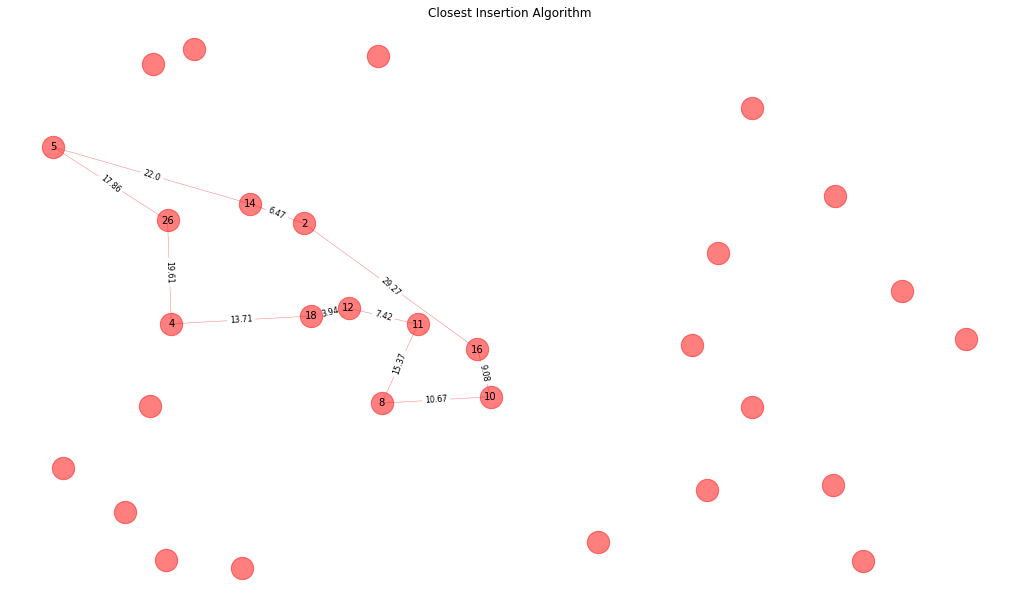

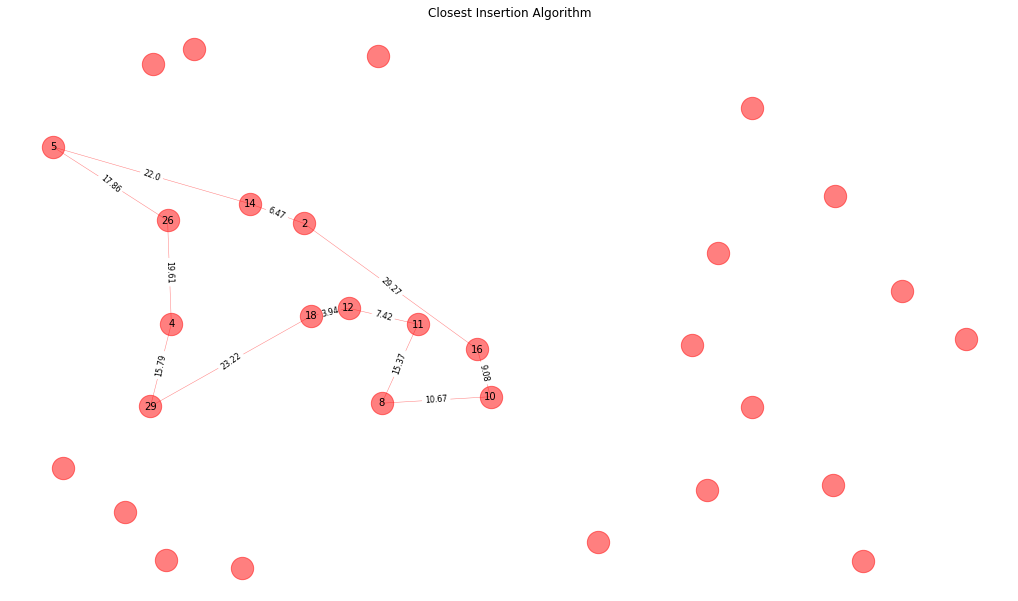

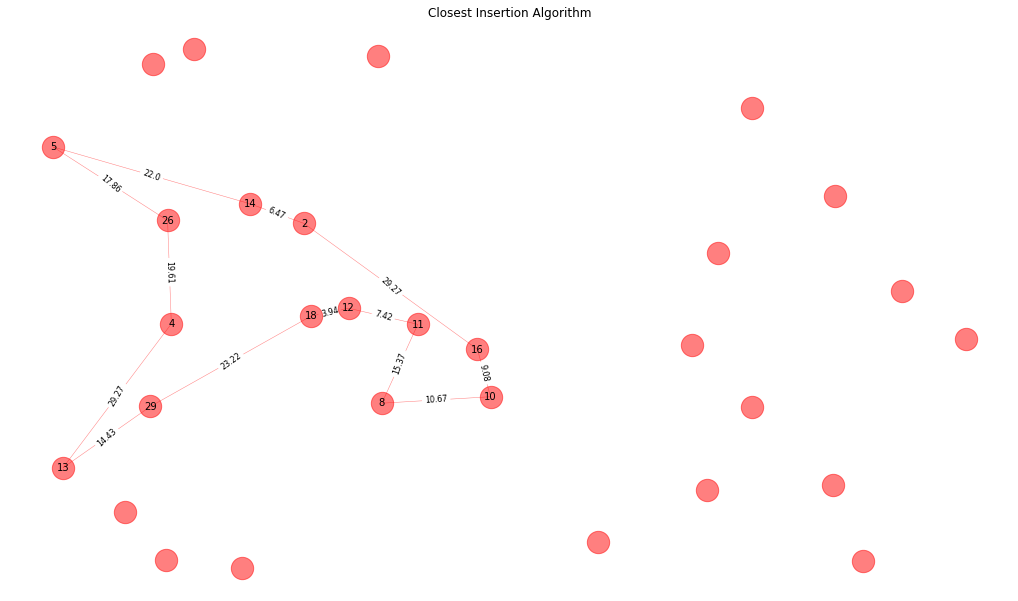

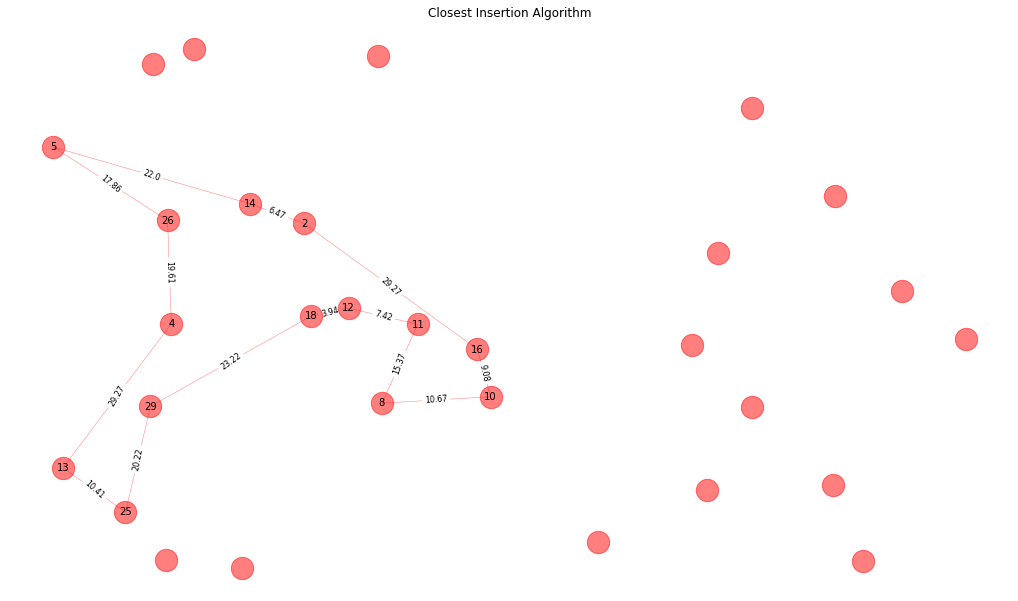

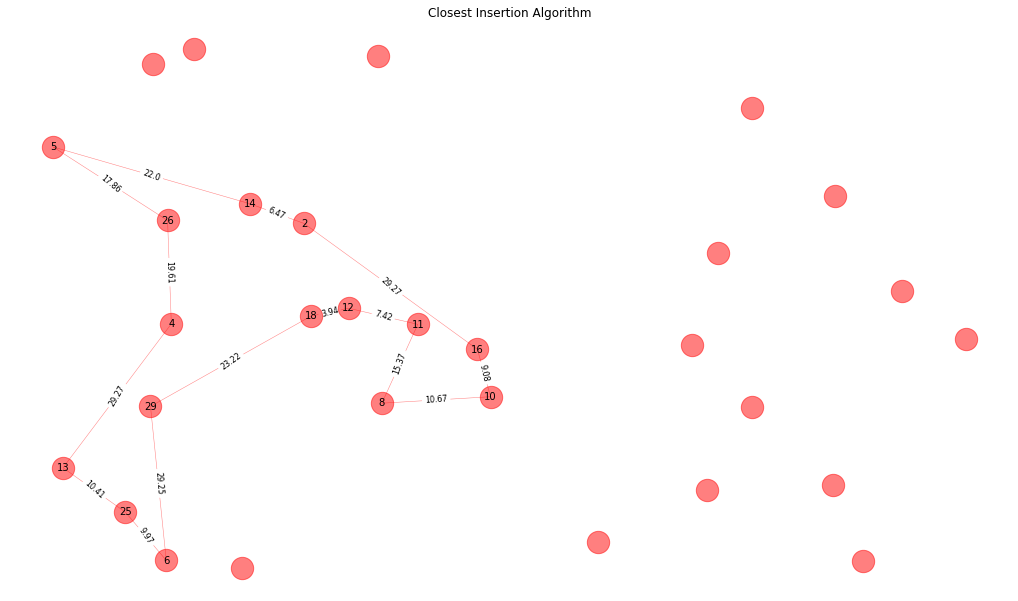

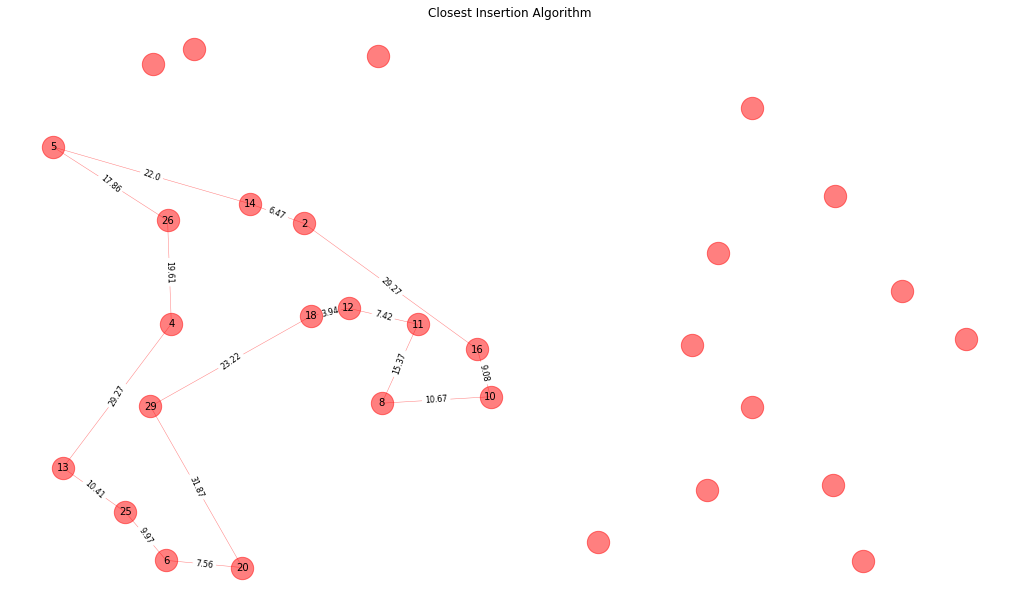

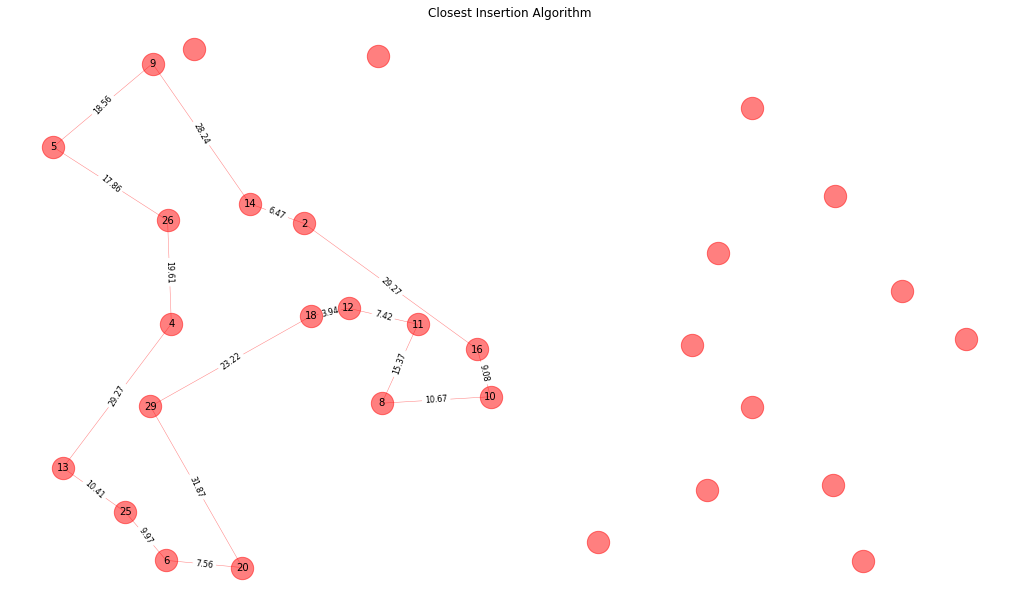

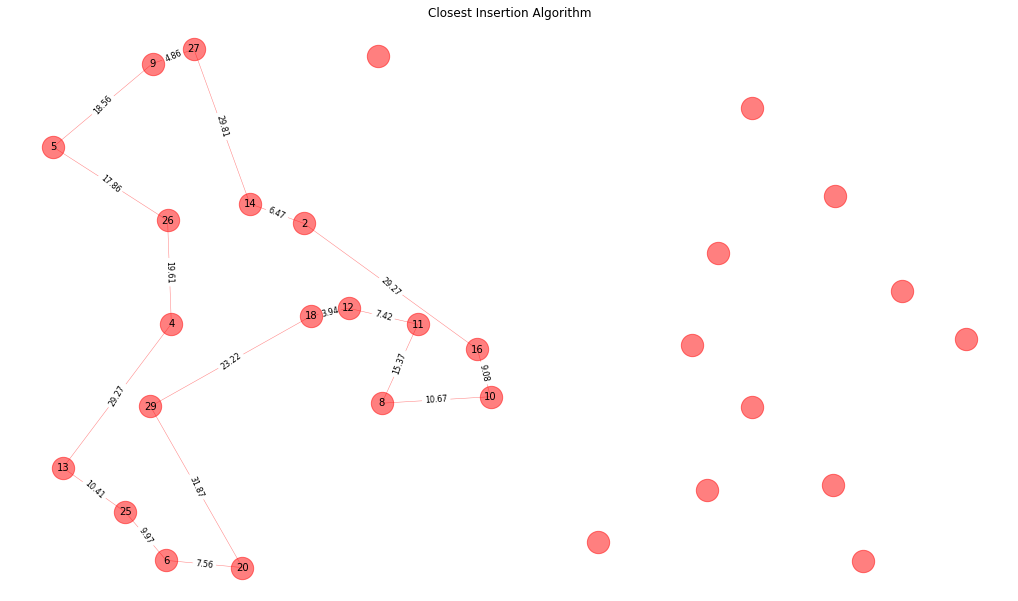

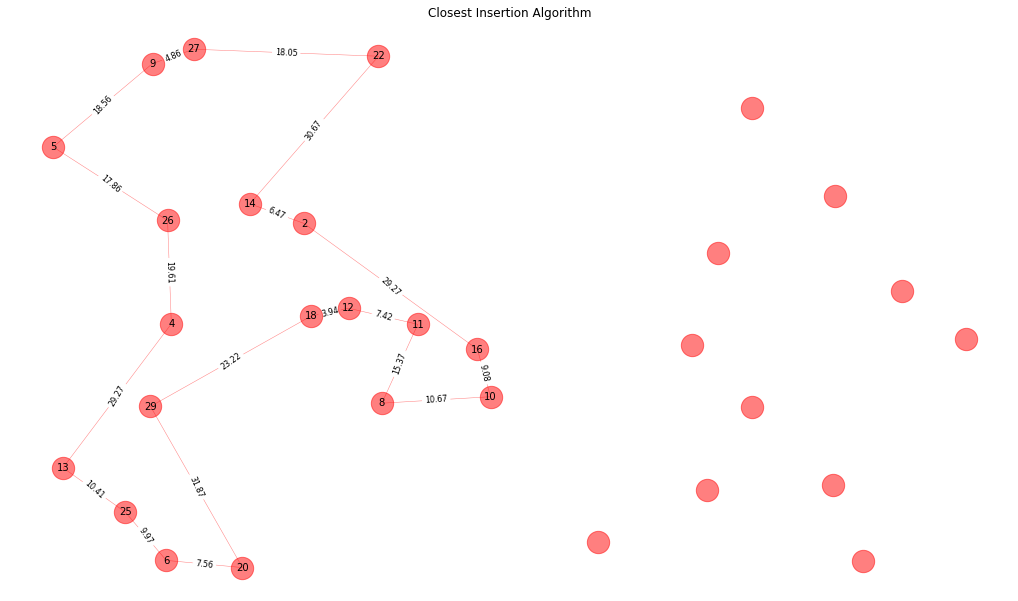

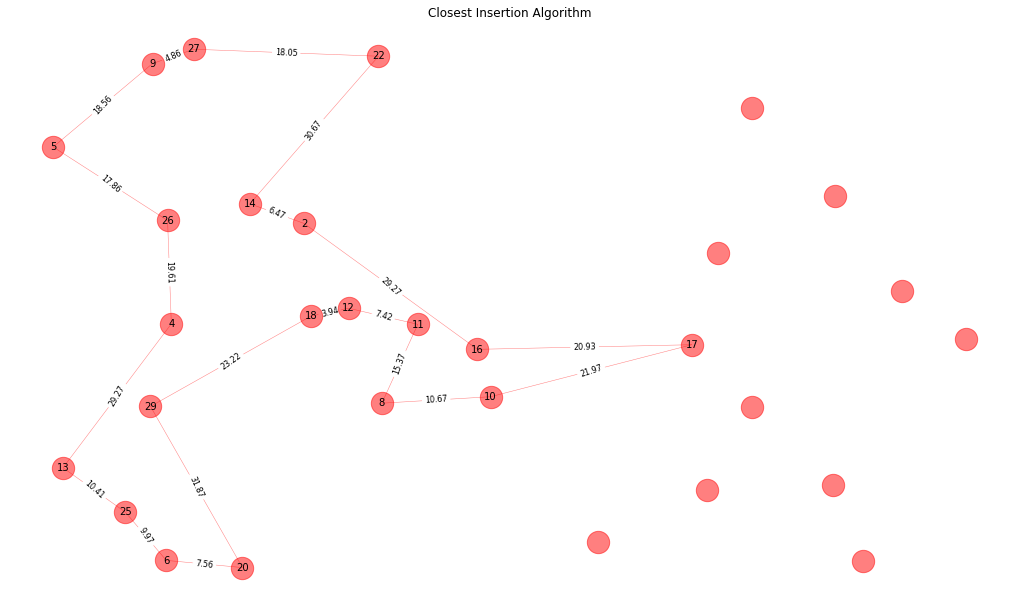

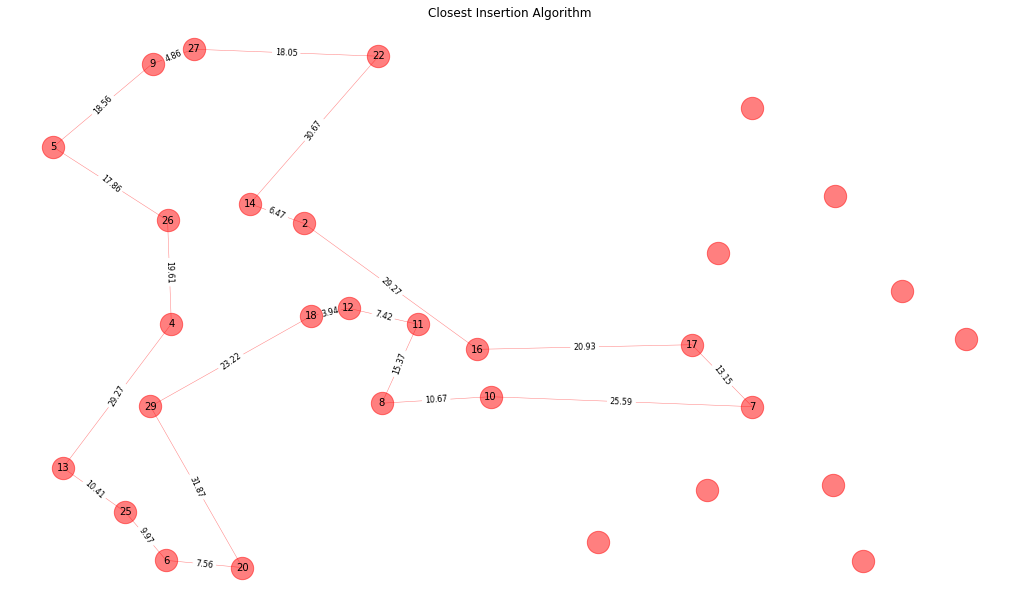

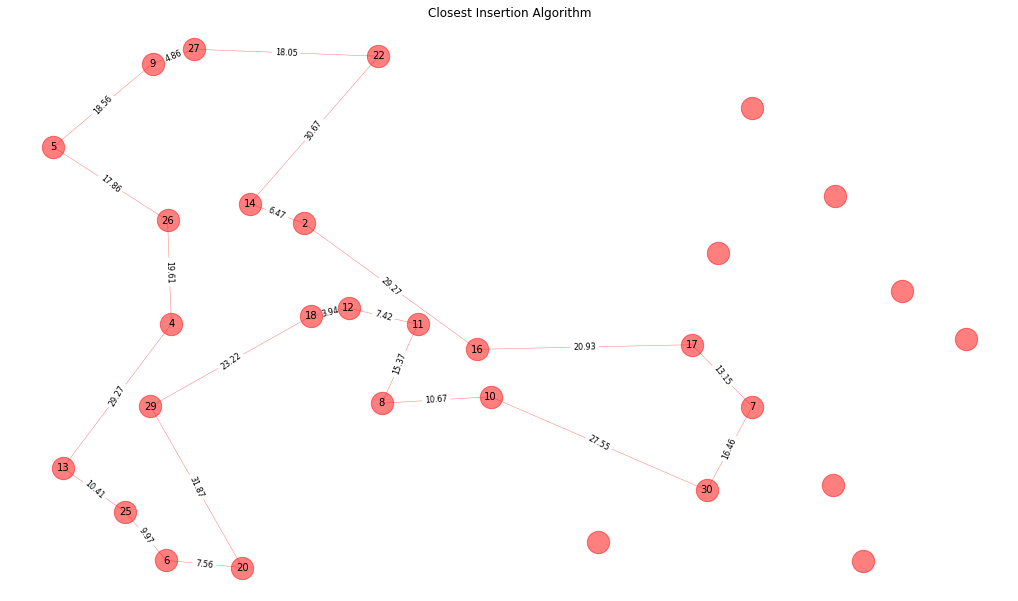

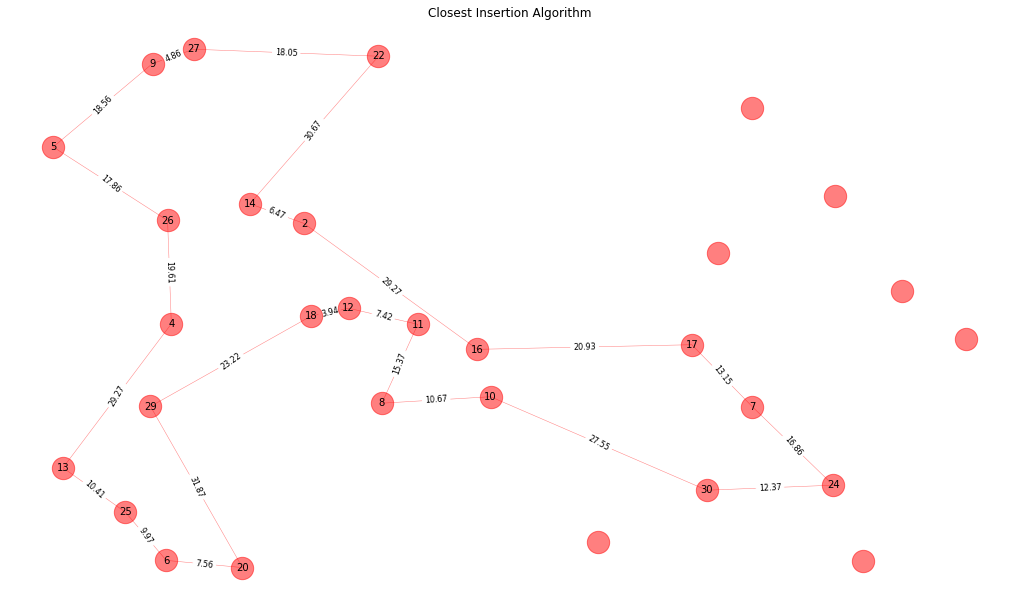

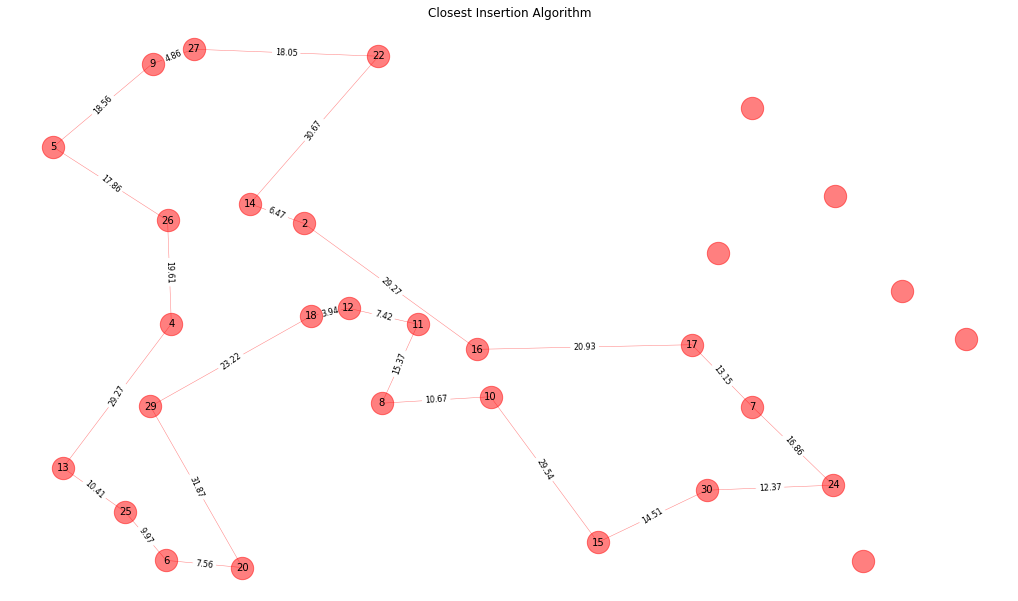

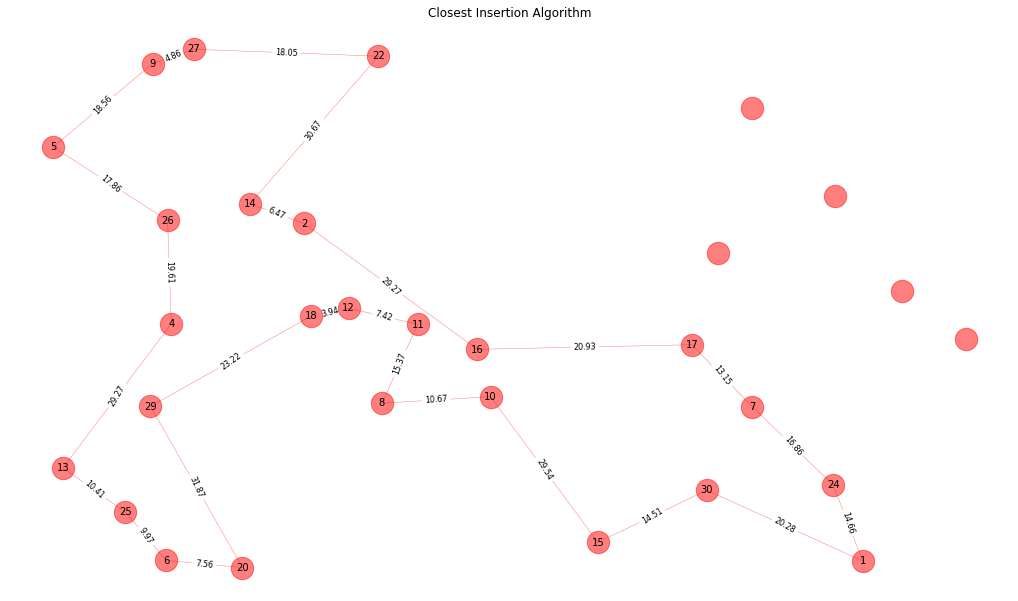

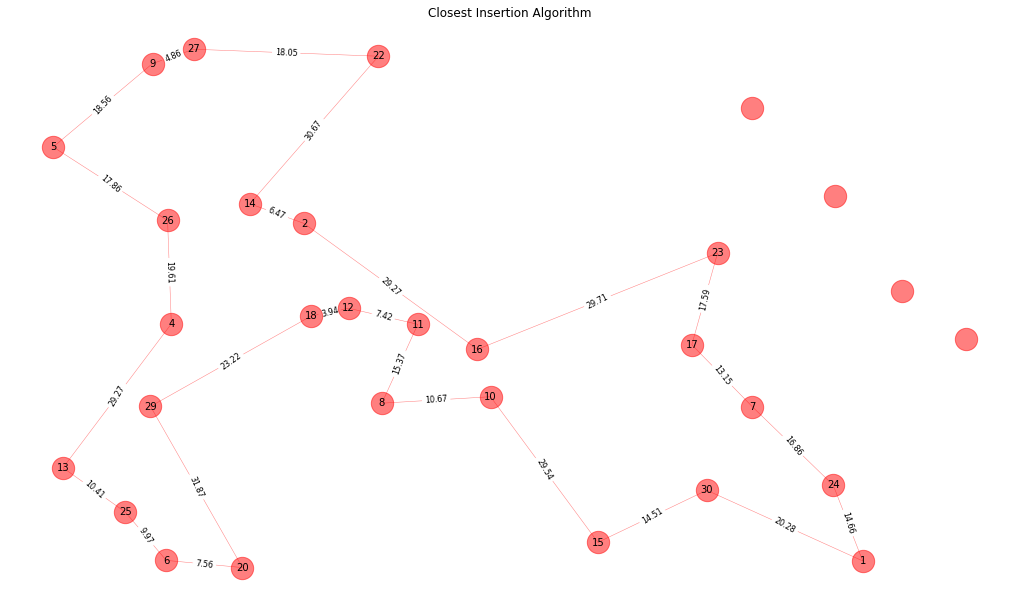

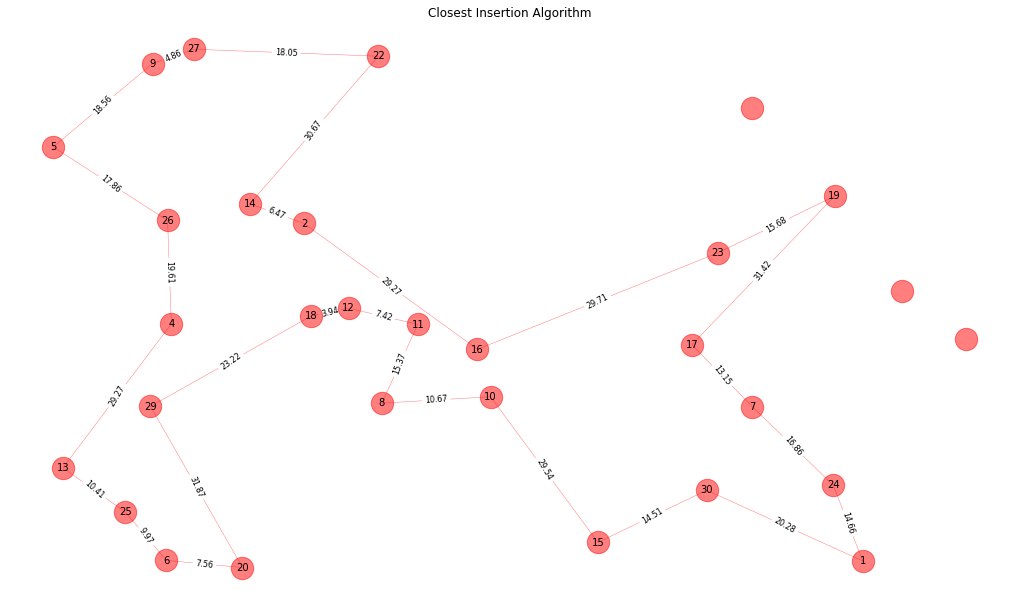

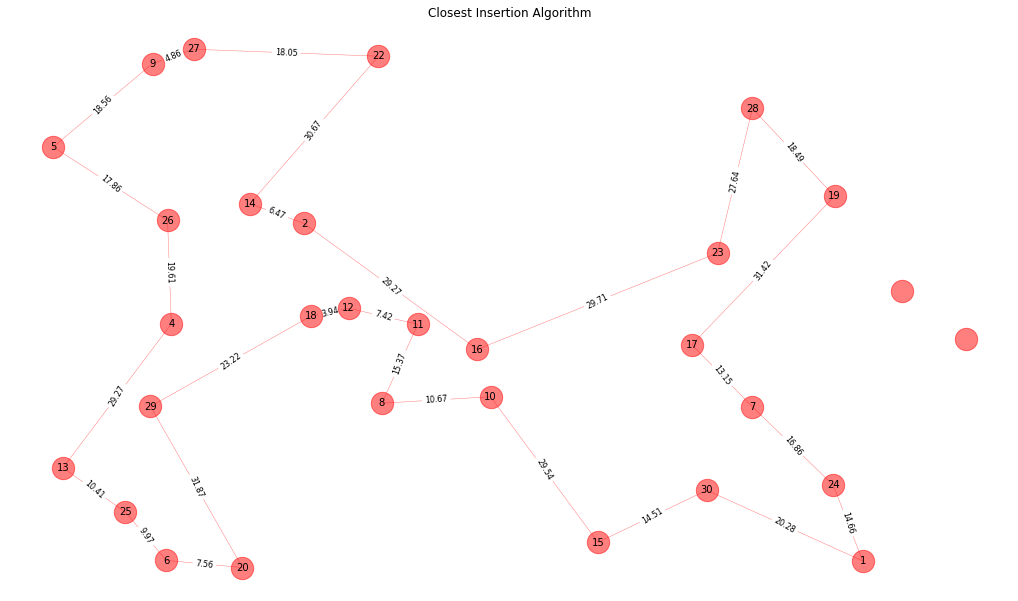

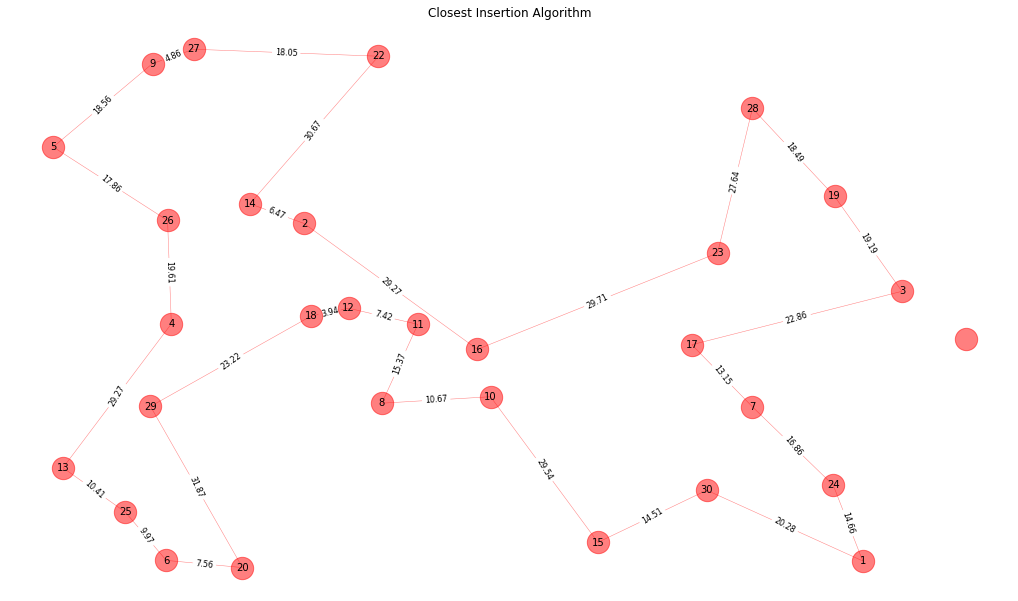

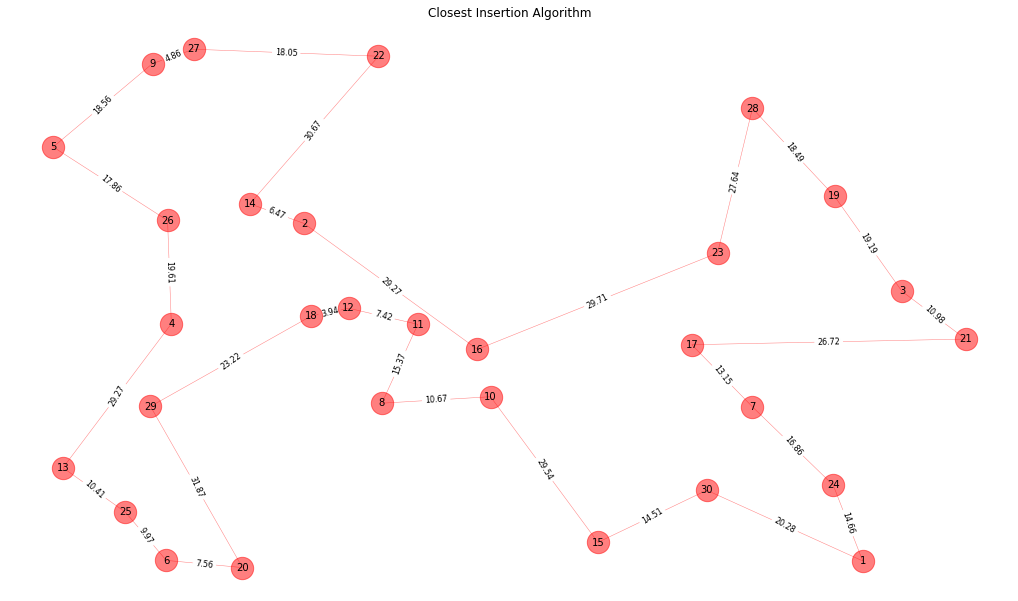

In [3]:
# Plot all paths in nearest insertion algorithm

for i in range(len(test[0])):
    graph.draw_closest_insertion( test[0][i], weights=True)
# Reset index for file name
graph.reset_file_index()

In [4]:
# Generate gif images from png plots

import os
import imageio

file_dir = 'nearest_insertion_algorithm.gif'
images_dir = 'graphs'
image_list = []

# Generate a list of absolute paths to the png images
filelist= sorted([os.path.abspath(f'{images_dir}/{file}') for file in os.listdir(images_dir) if file.endswith('.png')])
for file_name in filelist:
    image_list.append(imageio.imread(file_name))
    
# Create gif file 
kargs = { 'duration': 1 }
imageio.mimwrite(file_dir , image_list, **kargs)


In [5]:
# Display GIF image
from IPython.display import Image
Image(url=file_dir)  